# Installations + Google Drive

In [ ]:
!pip install PyPDF2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.6/232.6 kB 3.8 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
import os
datadir = "/content/drive/My Drive/CS568/568_Final_Project"
os.chdir(datadir)
!pwd

/content/drive/My Drive/CS568/568_Final_Project


# Extraction for fine-tuning

In [ ]:
prompt = "Assume the role of a mental health assistant trying to help a person deal with their problems. Use open-ended questions and help the person validate their feelings and reflect on their situation. Process the following context, and respond to the last patient message: "

In [ ]:
global_results = []

In [ ]:
import json
import unicodedata

def process_for_gemini(message):
    global global_results

    message = message[1:]
    for i in range(6, len(message)):
        if message[i]['role'] == 'assistant' and len(message[i]['content'].split(' ')) > 50:
            therapist_txt = message[i]['content'].replace("\\", "")
            user_text = ['patient: ' + '"' + message[i - k]['content'] + '" ' if k % 2 else 'mental health assistant: ' + '"' + message[i - k]['content'] + '" ' for k in range(6, 0, -1)]
            total_user = ""
            for i in range(len(user_text)):
                total_user += user_text[i].replace("\\", "")
            total_user = total_user.replace("\'", "'")
            total_user = unicodedata.normalize("NFKC", total_user)
            x = {
                "text_input": prompt + total_user,
                "output": therapist_txt
            }
            global_results.append(x)

In [ ]:
import os
import json
import PyPDF2
import re
from pathlib import Path

def clean_line(line):
    """
    Removes timestamps like [00:00:12] and parenthetical cues like (pause), including malformed ones.
    """
    # Remove timestamps like [00:03:08]
    line = re.sub(r'\[\d{2}:\d{2}:\d{2}\]', '', line)

    # Remove complete parentheticals: (pause), (throat clears), etc.
    line = re.sub(r'\([^()]*\)', '', line)
    line = re.sub(r'\[[^[]]*\]', '', line)

    # Remove malformed parentheticals without closing ')'
    line = re.sub(r'\([^\)]*$', '', line)

    return line.strip()

def extract_multi_turn_messages(text):
    """
    Converts the full PDF text into a list of OpenAI-formatted role messages.
    """
    messages = []
    current_role = None
    current_content = ""

    for raw_line in text.splitlines():
        line = clean_line(raw_line.strip())
        # skip blank lines
        if not line:
            continue

        # skip end of transcript
        if line.startswith("END TRANSCRIPT"):
            continue

        if line.startswith("CLIENT"):
            if current_role and current_content:
                messages.append({"role": current_role, "content": current_content.strip()})
            current_role = "user"
            current_content = line[len("CLIENT"):].strip()
            current_content = current_content.replace(':', '', 1).strip()

        elif line.startswith("THERAPIST"):
            if current_role and current_content:
                messages.append({"role": current_role, "content": current_content.strip()})
            current_role = "assistant"
            current_content = line[len("THERAPIST"):].strip()
            current_content = current_content.replace(':', '', 1).strip()

        else:
            # Continuation of the previous message
            current_content += " " + line.strip()

    if current_role and current_content:
        messages.append({"role": current_role, "content": current_content.strip()})

    # make sure that everything starts with user / client
    if messages:
        while messages[0]["role"] != "user":
            messages = messages[1:]

    if messages:
        while messages[-1]["role"] != "assistant":
            messages = messages[:-1]

    system = {"role": "system", "content": prompt}
    messages.insert(0, system)
    # Ensure message alternation starts with user
    return messages if len(messages) >= 3 else None

def clean_page(text):
    lines = text.strip().splitlines()

    if not lines or len(lines) < 2:
        return ""

    # remove last line (url)
    lines = lines[:-1]

    cleaned_lines = []
    date_pattern = re.compile(r"\d{1,2}/\d{1,2}/\d{2,4}") # matches dates

    last_idx = len(lines) - 1

    match = date_pattern.search(lines[last_idx])
    if match:
        lines[last_idx] = lines[last_idx][:match.start()].strip()

    # normalize unicode (get rid of \ufb01 type characters)
    joined = "\n".join(line.strip() for line in lines if line.strip())
    normalized = unicodedata.normalize("NFKC", joined)

    return normalized

def extract_text_from_pdf(pdf_path):
    with open(pdf_path, "rb") as f:
        reader = PyPDF2.PdfReader(f)
        pdf_text = []
        for page in reader.pages:
            text = page.extract_text() or ""
            cleaned_text = clean_page(text)
            pdf_text.append(cleaned_text)
        return "\n".join(pdf_text)

def process_pdfs_to_gemini(input_path):
    all_threads = []
    datadir = input_path + "/training_pdfs"
    for file_name in os.listdir(datadir):
        if file_name.endswith(".pdf"):
            file_path = os.path.join(datadir, file_name)
            raw_text = extract_text_from_pdf(file_path)
            message_thread = extract_multi_turn_messages(raw_text)

            if message_thread:
                process_for_gemini(message_thread)

process_pdfs_to_gemini(datadir)

In [ ]:
print(len(global_results))

# Fine-tuning Setup

In [ ]:
!pip install -q google-generativeai

In [ ]:
import google.generativeai as genai

In [ ]:
from google.colab import userdata
genai.configure(api_key="")

In [ ]:
for i, m in zip(range(5), genai.list_tuned_models()):
  print(m.name)

tunedModels/therapist-4776
tunedModels/therapist-9001
tunedModels/therapist-4375
tunedModels/therapist-4917


therapist-4776: 5 epochs, first 500 entries, 32 batch

therapist-9001: no idea, tried cancelling during training

therapist-4375: 10 epochs, first 750 entries, 32 batch

therapist-4917: 12 epochs, all entries, 64 batch

## Create new fine-tuned model

To create a tuned model, you need to pass your dataset to the model in the `genai.create_tuned_model` method. You can do this be directly defining the input and output values in the call or importing from a file into a dataframe to pass to the method.

In [ ]:
base_model = [
    m for m in genai.list_models()
    if "createTunedModel" in m.supported_generation_methods and
    "flash" in m.name][0]
base_model

Model(name='models/gemini-1.5-flash-001-tuning',
      base_model_id='',
      version='001',
      display_name='Gemini 1.5 Flash 001 Tuning',
      description=('Version of Gemini 1.5 Flash that supports tuning, our fast and versatile '
                   'multimodal model for scaling across diverse tasks, released in May of 2024.'),
      input_token_limit=16384,
      output_token_limit=8192,
      supported_generation_methods=['generateContent', 'countTokens', 'createTunedModel'],
      temperature=1.0,
      max_temperature=2.0,
      top_p=0.95,
      top_k=64)

In [ ]:
import random

name = f'therapist-{random.randint(0,10000)}'
operation = genai.create_tuned_model(
    # You can use a tuned model here too. Set `source_model="tunedModels/..."`
    source_model=base_model.name,
    training_data=global_results,
    id = name,
    epoch_count = 12,
    batch_size=64,
    learning_rate=0.001,
)

Your tuned model is immediately added to the list of tuned models, but its status is set to "creating" while the model is tuned.

In [ ]:
model = genai.get_tuned_model(f'tunedModels/{name}')

model

TunedModel(name='tunedModels/therapist-4917',
           source_model='models/gemini-1.5-flash-001-tuning',
           base_model='models/gemini-1.5-flash-001-tuning',
           display_name='',
           description='',
           temperature=1.0,
           top_p=0.95,
           top_k=64,
           state=<State.CREATING: 1>,
           create_time=datetime.datetime(2025, 5, 7, 8, 53, 4, 563554, tzinfo=datetime.timezone.utc),
           update_time=datetime.datetime(2025, 5, 7, 8, 53, 4, 563554, tzinfo=datetime.timezone.utc),
           tuning_task=TuningTask(start_time=None,
                                  complete_time=None,
                                  snapshots=[],
                                  hyperparameters=Hyperparameters(epoch_count=12,
                                                                  batch_size=64,
                                                                  learning_rate=0.001)),
           reader_project_numbers=None)

In [ ]:
model.state

<State.CREATING: 1>

### Check tuning progress

Use `metadata` to check the state:

In [ ]:
operation.metadata

total_steps: 204
tuned_model: "tunedModels/therapist-4917"

Wait for the training to finish using `operation.result()`, or `operation.wait_bar()`

In [ ]:
import time

for status in operation.wait_bar():
  time.sleep(30)

You can cancel your tuning job any time using the `cancel()` method. Uncomment the line below and run the code cell to cancel your job before it finishes.

In [ ]:
# operation.cancel()

Once the tuning is complete, you can view the loss curve from the tuning results. The [loss curve](https://ai.google.dev/gemini-api/docs/model-tuning#recommended_configurations) shows how much the model's predictions deviate from the ideal outputs.

<Axes: xlabel='epoch', ylabel='mean_loss'>

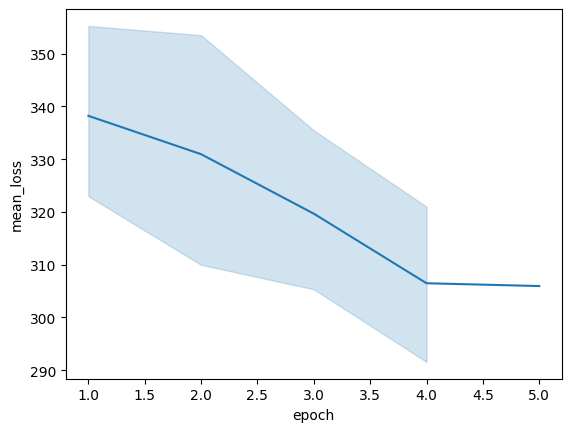

In [ ]:
import pandas as pd
import seaborn as sns

model = operation.result()

snapshots = pd.DataFrame(model.tuning_task.snapshots)

sns.lineplot(data=snapshots, x = 'epoch', y='mean_loss')


## Evaluate your model

You can use the `genai.generate_content` method and specify the name of your model to test your model performance.

In [ ]:
base_model = genai.GenerativeModel(model_name="gemini-1.5-flash")

In [ ]:
model_5_epochs = genai.GenerativeModel(model_name=f'tunedModels/therapist-4776')
model_10_epochs = genai.GenerativeModel(model_name=f'tunedModels/therapist-4375')
model_12_epochs = genai.GenerativeModel(model_name=f'tunedModels/therapist-4917')

In [ ]:
global_eval = []

In [ ]:
import json
import unicodedata
import time
start = None
api_calls = 0

def gemini_eval(message):
    global global_eval, start, api_calls
    message = message[1:]
    for i in range(4, len(message)):
        if message[i]['role'] == 'assistant' and len(message[i]['content'].split(' ')) > 50:
            if time.time() - start > 60 and api_calls < 13:
                start = time.time()
                api_calls = 0
            elif api_calls > 13:
                time.sleep(65 - (time.time() - start))
                start = time.time()
                api_calls = 0
            therapist_txt = message[i]['content'].replace("\\", "")
            user_text = ['patient: ' + '"' + message[i - k]['content'] + '" ' if k % 2 else 'mental health assistant: ' + '"' + message[i - k]['content'] + '" ' for k in range(4, 0, -1)]
            total_user = ""
            for i in range(len(user_text)):
                total_user += user_text[i].replace("\\", "")
            total_user = total_user.replace("\'", "'")
            total_user = unicodedata.normalize("NFKC", total_user)
            text_input = prompt + total_user
            try:
                finetuned_result = model_10_epochs.generate_content(text_input)
                base_result = base_model.generate_content(text_input)
                api_calls += 2
            except:
                print("text generation failed")
                continue
            x = None
            try:
                x = {
                    "text_input": text_input,
                    "therapist_result": therapist_txt,
                    "base_result": base_result.text,
                    "finetuned_result": finetuned_result.text
                }
            except:
                try:
                    x = {
                        "text_input": text_input,
                        "therapist_result": therapist_txt,
                        "base_result": base_result,
                        "finetuned_result": finetuned_result
                    }
                except:
                    print("both texts failed")
                    continue
            global_eval.append(x)

In [ ]:
import os
import json
import PyPDF2
import re
from pathlib import Path

def clean_line(line):
    """
    Removes timestamps like [00:00:12] and parenthetical cues like (pause), including malformed ones.
    """
    # Remove timestamps like [00:03:08]
    line = re.sub(r'\[\d{2}:\d{2}:\d{2}\]', '', line)

    # Remove complete parentheticals: (pause), (throat clears), etc.
    line = re.sub(r'\([^()]*\)', '', line)
    line = re.sub(r'\[[^[]]*\]', '', line)

    # Remove malformed parentheticals without closing ')'
    line = re.sub(r'\([^\)]*$', '', line)

    return line.strip()

def process_eval(input_path):
    all_threads = []
    datadir = input_path + "/test_pdfs/sadness"
    for file_name in os.listdir(datadir):
        if file_name.endswith(".pdf"):
            file_path = os.path.join(datadir, file_name)
            raw_text = extract_text_from_pdf(file_path)
            message_thread = extract_multi_turn_messages(raw_text)

            if message_thread:
                print(file_name)
                gemini_eval(message_thread)

start = time.time()
process_eval(datadir)

Sadness1.pdf
Sadness2.pdf
Sadness3.pdf
Sadness4.pdf
Sadness5.pdf
Sadness6.pdf
Sadness7.pdf
Sadness8.pdf
Sadness9.pdf


In [ ]:
for i in global_eval:
    print(str(i) + ",")

{'text_input': 'Assume the role of a mental health assistant trying to help a person deal with their problems. Use open-ended questions and help the person validate their feelings and reflect on their situation. Process the following context, and respond to the last patient message: mental health assistant: "Right, so, you know , I think one of the things I see happening with you in here is you know we start talking about something and it brings up all this stuf f from your past and then you’re overcome with emotion because you never let yourself grieve it." patient: "Well, it’ s because I want everybody to feel better . You know , so..." mental health assistant: "I’m talking about you. Just you." patient: "I don’ t know ." ', 'therapist_result': 'Yeah. You know , do you realize that grieving someone is honoring the relationship you have with them. We never just get over . I mean you’ve had some huge losses and the theme in all of this is you know either you feel God speaking to you or

In [ ]:
print(len(global_eval))

38


## Delete the model

You can clean up your tuned model list by deleting models you no longer need. Use the `genai.delete_tuned_model` method to delete a model. If you canceled any tuning jobs, you may want to delete those as their performance may be unpredictable.

In [ ]:
genai.delete_tuned_model(f'tunedModels/{name}')

The model no longer exists:

In [ ]:
try:
  m = genai.get_tuned_model(f'tunedModels/{name}')
  print(m)
except Exception as e:
  print(f"{type(e)}: {e}")

<class 'google.api_core.exceptions.NotFound'>: 404 GET https://generativelanguage.googleapis.com/v1beta/tunedModels/generate-num-8122?%24alt=json%3Benum-encoding%3Dint: Tuned model tunedModels/generate-num-8122 does not exist.
